In [15]:
!pip install numpy pandas seaborn tqdm scipy scikit-learn diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.2 MB/s eta 0:00:00a 0:00:01


In [66]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm as tqdm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as sk_RFC
from sklearn.metrics import classification_report, log_loss, roc_curve, roc_auc_score, auc

## Train a Target Model

### Get and prepare the data

In [146]:
# Dataset: https://figshare.le.ac.uk/articles/dataset/Myocardial_infarction_complications_Database/12045261/3
# Myocardial infarction complications
from sklearn.preprocessing import StandardScaler

def get_heart_failure():
    df = pd.read_csv("https://figshare.le.ac.uk/ndownloader/files/23581310")
    complications = df.columns[-12:]
    target_complication = "ZSN"  # Chronic heart failure
    freq_na_cols = df.columns[df.isna().mean(axis=0) > 0.1]
    df = df.drop(columns=freq_na_cols).dropna()

    X = df.drop(columns=complications)
    y = df[target_complication]
    #X = df.drop(columns=target_complication)
    #y = df[target_complication]
    return X, y


def get_diabetes():
    df = pd.read_csv('datasets/diabetes.csv')

    df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
    df['Glucose'].fillna(df['Glucose'].mean(), inplace=True)
    df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace=True)
    df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace=True)
    df['Insulin'].fillna(df['Insulin'].mean(), inplace=True)
    df['BMI'].fillna(df['BMI'].mean(), inplace=True)
    
    target = "Outcome"
    X = df.drop(columns=target)
    y = df[target]

    return X, y

#X, y = get_heart_failure()
X, y = get_diabetes()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(X_train.columns)

### Fit a simple classifier

In [147]:
def train_model(X_train, y_train, seed=42):
    rfc = sk_RFC(
        n_estimators=200,
        min_samples_split=2,
        max_depth=10,
        random_state=seed,
    )
    rfc.fit(X_train, y_train)
    return rfc
    
target_model = train_model(X_train, y_train)

# The classifier's accuracy vs. random baseline. We are doing a bit better than the baseline.
print(f"Baseline: {max(y_test.mean(), 1 - y_test.mean()):0.2f}")
print(f"Our test-score: {target_model.score(X_test, y_test):0.2f}" )

Baseline: 0.76
Our test-score: 0.81


In [148]:
# The classifier's accuracy vs. random baseline. We are doing a bit better than the baseline.
print(f"Baseline: {max(y_test.mean(), 1 - y_test.mean()):0.2f}")
print(f"Our test-score: {target_model.score(X_test, y_test):0.2f}" )

Baseline: 0.76
Our test-score: 0.81


## Measuring Population-Wise Privacy Leakage

In [149]:
def measure_membership_vulnerability(vals_train, vals_test, target_fpr=0.01):
    vals = np.concatenate([vals_train, vals_test])
    membership_labels = np.concatenate([[1] * len(vals_train), [0] * len(vals_test)])
    best_tpr = 0.0
    best_threshold = None
    best_preds = np.zeros_like(vals)
    # We find a threshold which maximizes attack TPR for a given level of FPR.
    for threshold in vals:
        tpr = (vals_train > threshold).mean()
        fpr = (vals_test > threshold).mean()
        if fpr <= target_fpr and tpr > best_tpr:
            best_threshold = threshold
            best_tpr = tpr
            best_preds = (vals > threshold)
    
    return membership_labels, best_preds

In [150]:
def logit_scale(y_true, y_pred, eps=1e-16):
    """
    Logit scaling from https://arxiv.org/abs/2112.03570
    """
    if isinstance(y_true, np.integer):
        y_true = [y_true] * len(y_pred)
        
    result = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for i in range(len(y_true)):
        y = y_true[i]
        pred = y_pred[i, y]
        result.append(
            np.log(np.clip(pred / np.clip(1 - pred, eps, np.inf), eps, np.inf))
        )
    return np.array(result)

In [151]:
def visualize_vals(train_vals, test_vals):
    """Visualize feature values on train and test data."""
    return sns.displot(
        data=pd.concat([
                pd.DataFrame(dict(val=train_vals)).assign(membership="train"),
                pd.DataFrame(dict(val=test_vals)).assign(membership="test"),
        ]),
        x="val",
        hue="membership",
        kind="hist",
        stat="probability",
        rug=True,
        common_norm=False
   )

In [152]:
# Extract the features for the membership inference attack.
preds_train = target_model.predict_proba(X_train)
preds_test = target_model.predict_proba(X_test)

logits_train = logit_scale(y_train, preds_train)
logits_test = logit_scale(y_test, preds_test)

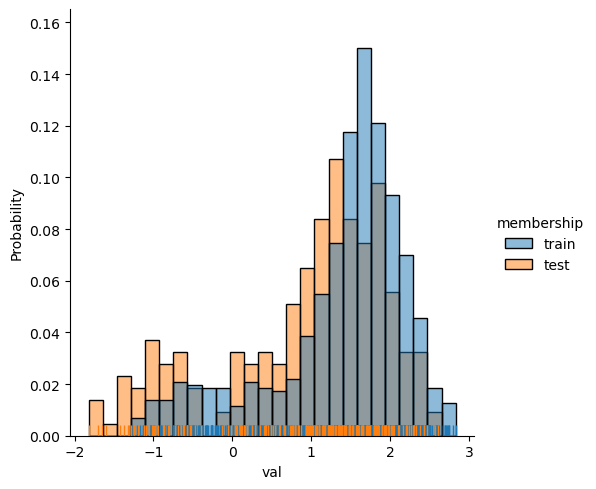

In [153]:
# Visualize the features. If it is possible to tell train data from test data, then
# our model is vulnerable to membership inference.
visualize_vals(logits_train, logits_test)

### What's the membership attack TPR at a given FPR?

In [154]:
target_fpr = 0.5
membership_labels, membership_preds = measure_membership_vulnerability(
    logits_train, logits_test, target_fpr
)
print(f"Attack TPR = {(membership_preds[membership_labels == 1] == 1).mean():.2%} @ FPR = {target_fpr:.2%}")

Attack TPR = 71.01% @ FPR = 50.00%


### ROC curve of the membership attack

<Axes: xlabel='FPR', ylabel='TPR'>

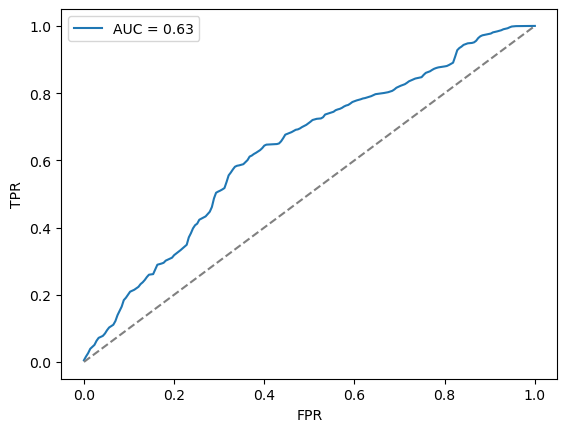

In [155]:
# In principle, we do not even need to implement the threshold selection in `measure_membership_vulnerability`.
# Here I am just using roc_curve from scikit-learn.

fpr, tpr, _ = roc_curve(membership_labels, np.concatenate([logits_train, logits_test]))
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')

## Protect against leakage

Now that we know how much that we're leaking privacy-wise, we can apply the `Opacus / DiffPrivLib` library
to our model and see how the ROC curve flattens.

In [157]:
from diffprivlib.models import RandomForestClassifier as dp_RFC

rfc_dp = dp_RFC(
    n_estimators=80,
#     min_samples_split=2,
    max_depth=10,
    random_state=42,
    epsilon=1e100,
    bounds=(np.min(X_train, axis=0), np.max(X_train, axis=0)),
    classes=np.unique(y_train),
)

target_model = rfc_dp.fit(X_train, y_train)
# The classifier's accuracy vs. random baseline. We are doing a bit better than the baseline.
print(f"Baseline: {max(y_test.mean(), 1 - y_test.mean()):0.2f}")
print(f"Our test-score: {target_model.score(X_test, y_test):0.2f}" )

Baseline: 0.76
Our test-score: 0.76


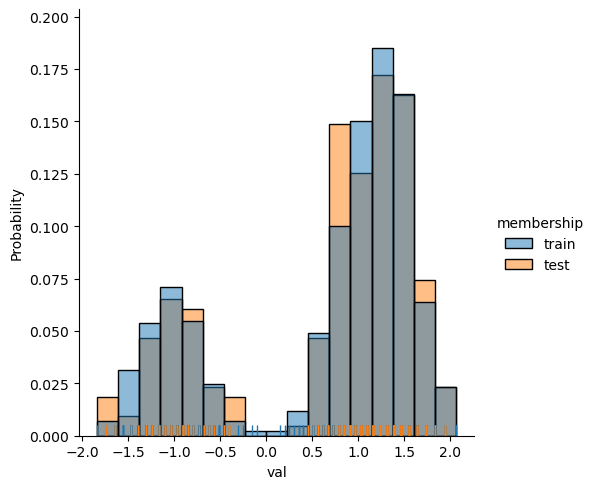

In [158]:
# Extract the features for the membership inference attack.
preds_train = target_model.predict_proba(X_train)
preds_test = target_model.predict_proba(X_test)

logits_train = logit_scale(y_train, preds_train)
logits_test = logit_scale(y_test, preds_test)

# Visualize the features. If it is possible to tell train data from test data, then
# our model is vulnerable to membership inference.
visualize_vals(logits_train, logits_test)

<Axes: xlabel='FPR', ylabel='TPR'>

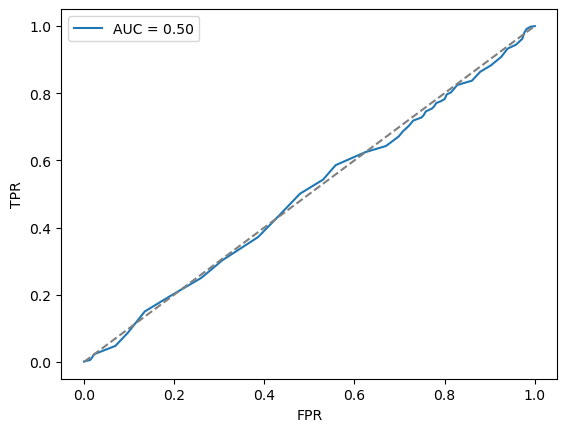

In [159]:
# In principle, we do not even need to implement the threshold selection in `measure_membership_vulnerability`.
# Here I am just using roc_curve from scikit-learn.
fpr, tpr, _ = roc_curve(membership_labels, np.concatenate([logits_train, logits_test]))
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')

## Measuring True Privacy Leakage

In [53]:
def compute_feature_func(func, models):
    return np.array([func(model) for model in models])

In [54]:
num_examples_to_attack = 50
num_ref_models = 10

# Collect some arbitrary target examples to attack.
examples_to_attack = []

# ...half from the training data.
for index in X_train.index[:num_examples_to_attack // 2]:
    examples_to_attack.append((index, X_train.loc[index], y_train.loc[index], 1))
    
# ...half from the test data.
for index in X_test.index[:num_examples_to_attack // 2]:
    examples_to_attack.append((index, X_test.loc[index], y_test.loc[index], 0))

result = []

# Now run the re-training attacks!
for index, x, y, is_member in tqdm(examples_to_attack):
    # First, train a bunch of models without the target example (if it is in fact part of the training data)
    out_models = []
    for seed in range(num_ref_models):
        ref_model = train_model(
            X_train.drop(index=[index], errors="ignore"),
            y_train.drop(index=[index], errors="ignore"),
            seed=seed
        )
        out_models.append(ref_model)
    
    # Compute the attack features.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        preds_in = compute_feature_func(lambda model: model.predict_proba([x])[0], [target_model])
        preds_out = compute_feature_func(lambda model: model.predict_proba([x])[0], out_models)
    
    logit_in = logit_scale(y, preds_in)[0]
    logits_out = logit_scale(y, preds_out)
    
    # Next, we run a parametric test. We assume that "out" logits are Gaussian-distributed, 
    # so compute their mean and variance.
    logits_out_mean = np.mean(logits_out)
    logits_out_var = np.var(logits_out)
    
    # The parametric test is computing the probability that the "out" logits are less than "in" logit,
    # which means that we predict the target record as a member:
    # 
    #   Pr[logit_out <= logit_in], where logit_out ~ Normal(mean, var) with mean and var
    #   estimated from reference models.
    #
    # See https://arxiv.org/abs/2112.03570, Eq. (4)
    prob = stats.norm(logits_out_mean, logits_out_var).cdf(logit_in) 
    
    result.append(dict(
        target_index=index,
        is_member=is_member,
        prob=prob,
    ))

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.81it/s]


<Axes: xlabel='FPR', ylabel='TPR'>

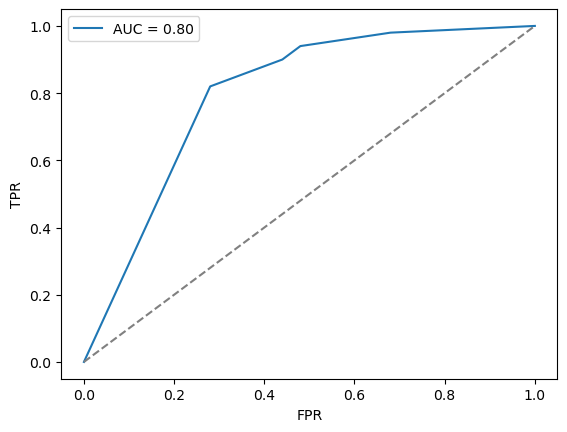

In [55]:
fpr, tpr, _ = roc_curve(pd.DataFrame(result).is_member, pd.DataFrame(result).prob)
roc_auc = auc(fpr, tpr)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

sns.lineplot(x='FPR', y='TPR', data=roc_df, label=f"AUC = {roc_auc:0.2f}", errorbar=None)
sns.lineplot(x=[0, 1], y=[0, 1], color='grey', linestyle='--')